In [3]:
#Import neccesary packages
import torch
import numpy as np
import pandas as pd
import model
import data
import sklearn

# Pretrained Word Embeddings

In [4]:
# Using pretrained GloVe 6 Billion Tokens embeddings
# To download, please go to: http://nlp.stanford.edu/data/glove.6B.zip
# To download more complex version: https://nlp.stanford.edu/projects/glove/

#Specify GloVe embeddings files directory
glove_home = '/Users/zhuorulin/Documents/DataScience/datasets/glove.6B/'

#Import only a portion of words for testing
words_to_load = 50000

import numpy as np

#Using 50 dimension embeddding for testing
with open(glove_home + 'glove.6B.50d.txt') as f:
    loaded_embeddings = np.zeros((words_to_load, 50))
    words = {}
    ordered_words = []
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        
        s = line.split()
        loaded_embeddings[i, :] = np.asarray(s[1:])
        words[s[0]] = i
        ordered_words.append(s[0])

FileNotFoundError: [Errno 2] No such file or directory: '/Users/zhuorulin/Documents/DataScience/datasets/glove.6B/glove.6B.50d.txt'

In [5]:
#To access the word embedding of certain word use the format loaded_embedings[words['someword']]
#Example:
loaded_embeddings[words['something']]

array([ 0.39533  , -0.0064782, -0.26112  , -0.32292  ,  0.96181  ,
        0.11242  , -0.30927  ,  0.17085  , -0.38948  ,  0.77584  ,
       -0.31334  ,  0.54971  , -0.4579   ,  0.05835  ,  1.0643   ,
        0.57949  ,  0.74198  ,  0.22064  ,  0.11507  , -0.84422  ,
       -0.43365  ,  0.52626  ,  0.067037 ,  0.16294  ,  1.1345   ,
       -2.0336   , -1.211    ,  0.69115  ,  1.418    , -0.80188  ,
        3.0172   ,  0.36111  , -0.38275  , -0.51099  , -0.19531  ,
       -0.16375  , -0.024037 ,  0.32332  , -0.0070115, -0.49139  ,
       -0.28394  ,  0.06881  , -0.11819  ,  0.47825  ,  0.16551  ,
        0.29805  ,  0.010174 ,  0.20346  , -0.13682  ,  0.79782  ])

# How to access saved model and its embedding
(For t-SNE plotting)
An example of trained model file outputed by main.py can be obtained by simply running 
python main.py

In [6]:
test_model = torch.load('./saved_models/baseline_20epcs.pt')

AssertionError: Torch not compiled with CUDA enabled

In [5]:
#Access embedding encoder
embeddings = test_model.encoder

In [6]:
#Access the embedding of certain index
index = torch.autograd.Variable(torch.LongTensor([1]))
print(embeddings(index).data.numpy())

[[ 0.0584227   0.06738488 -0.09146285  0.09027602 -0.00553663  0.06121026
  -0.02869502  0.09575699  0.00909212 -0.0371874   0.09213921 -0.06997923
  -0.00163003  0.00070393  0.09747472  0.0730431   0.050972   -0.09374902
   0.09427254 -0.02971593 -0.01190037  0.09512663  0.09175614  0.06701317
  -0.06477593  0.06747179 -0.03590024  0.09678961 -0.02077954 -0.03717487
   0.09399399  0.05078898 -0.03373756  0.07167596 -0.01005025 -0.08891959
   0.01151292  0.08840706  0.05733902 -0.0304296  -0.0959112   0.09701306
  -0.0543106  -0.09391937 -0.06585642  0.00093385 -0.02688372 -0.07140672
   0.09044622  0.0079434 ]]


In [7]:
print(embeddings(index).data.numpy().shape)

(1, 50)


In [9]:
embeddings.weight.data


 6.9161e-02 -7.4805e-02  6.9472e-02  ...  -5.3911e-02 -6.7033e-02  4.6637e-02
 5.8423e-02  6.7385e-02 -9.1463e-02  ...  -7.1407e-02  9.0446e-02  7.9434e-03
 9.3252e-02 -6.2379e-02 -4.9981e-02  ...  -8.9035e-02  5.9305e-02  9.1563e-02
                ...                   ⋱                   ...                
 2.4863e-02  1.1415e-01 -6.2715e-02  ...  -5.3927e-02 -7.8696e-02  1.4376e-01
-1.7399e-01 -5.9539e-02  5.8550e-02  ...  -3.3759e-02 -6.9809e-02 -4.1872e-02
-8.1804e-02  1.3174e-01 -1.2040e-01  ...   3.4032e-02 -8.4751e-02  1.1907e-01
[torch.FloatTensor of size 10000x50]

# Investigate Corpus

In [13]:
corpus = data.Corpus('../Starter_Codes/data/penn')
def batchify(data, bsz):
    nbatch = data.size(0) // bsz
    data = data.narrow(0, 0, nbatch * bsz)
    data = data.view(bsz, -1).t().contiguous()
    #if args.cuda:
        #data = data.cuda()
    return data

In [14]:
eval_batch_size = 10
train_data = batchify(corpus.train, 64)
val_data = batchify(corpus.valid, 64)
test_data = batchify(corpus.test, 64)

In [36]:
# Access word using index
print(corpus.dictionary.idx2word[1070])
# Access index using word
corpus.dictionary.word2idx['claims']

opened


1755

# t-sne ploting

In [56]:
# Using sklearn.manifold.TSNE package
# Documentation: http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
index_to_plot = torch.autograd.Variable(torch.LongTensor(np.arange(0,50,1)))
Embeddings_to_plot = embeddings(index_to_plot).data.numpy()

In [57]:
from sklearn.manifold import TSNE
TSNE_model = TSNE(n_components=2,random_state=0)
#Transfer to 2 dimensions
representations2D = TSNE_model.fit_transform(Embeddings_to_plot)

In [69]:
words_to_plot = corpus.dictionary.idx2word[:50]

In [70]:
import matplotlib.pyplot as plt

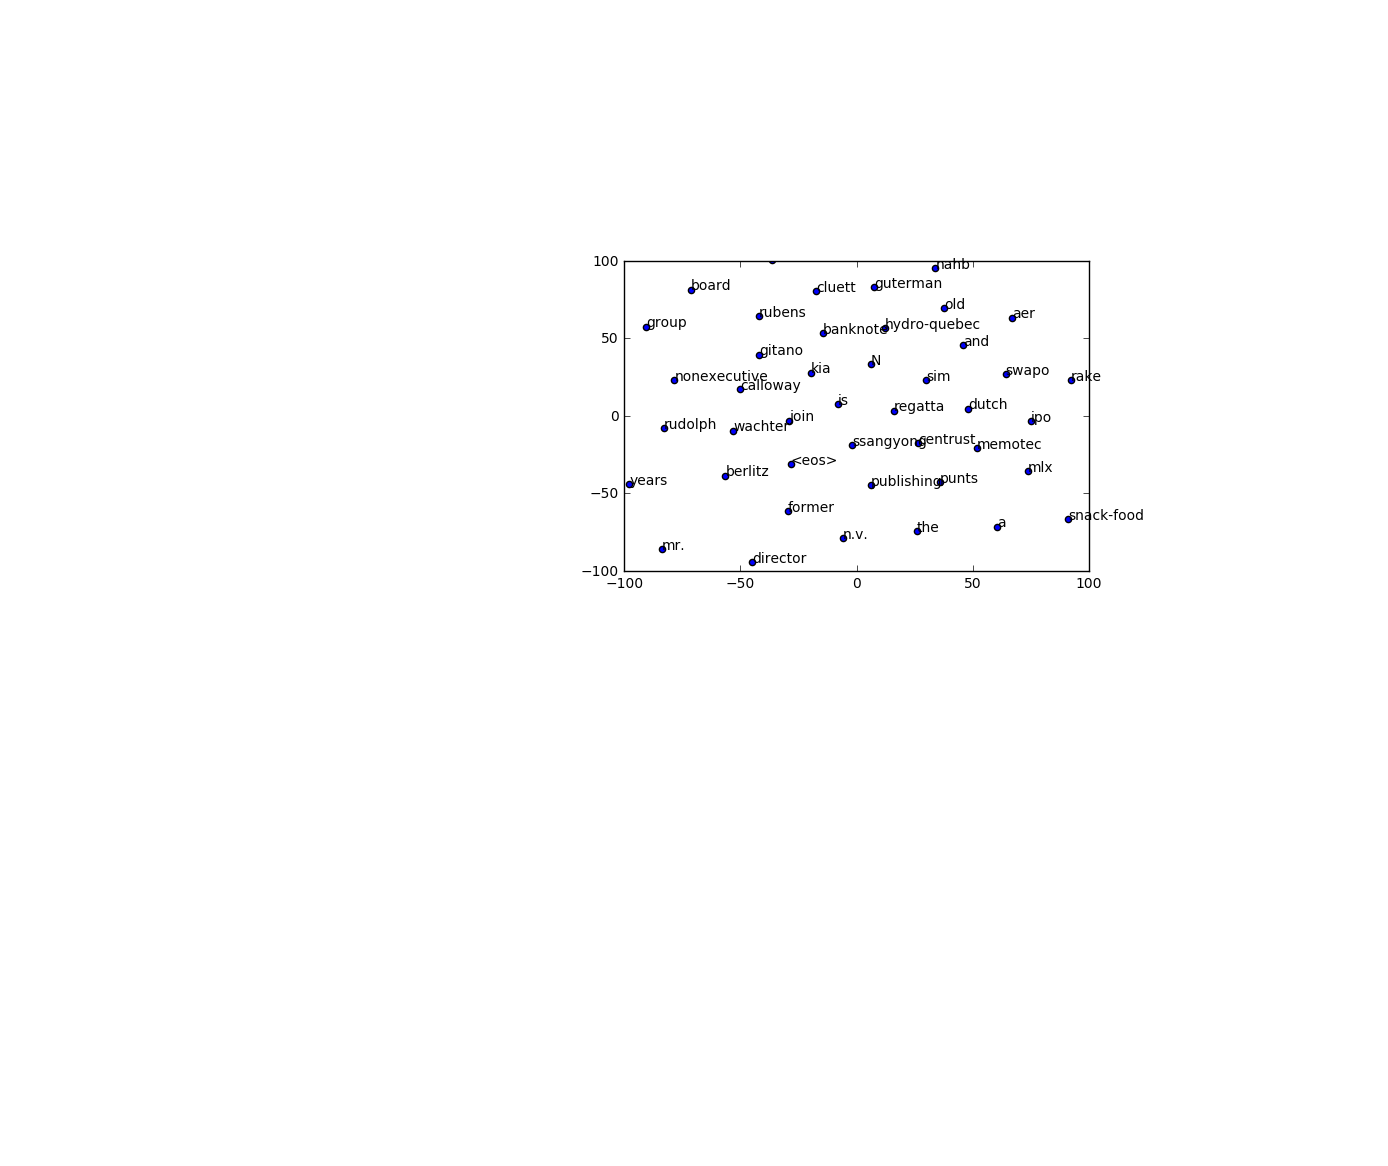

In [71]:
plt.scatter(representations2D[:,0],representations2D[:,1])
for word_idx,word in enumerate(words_to_plot):
    plt.annotate(word,representations2D[word_idx])
plt.xlim([-100,100])
plt.ylim([-100,100])
plt.show()

# Initialize embeddings with pretrained GloVe